#### Importing packages

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import sparse


### Importing Committee to Candidate donations
Format: CommitteeID, CandidateID, Time, Amount

What the candidate receives.

I think this is the inweight they talk about in [8]

In [ ]:
Com2Cand = np.loadtxt('/Users/vaishnan/Documents/15826/campaign-contribution-text/Com2Cand.txt',int)


### Importing Donor to Committee donations
Format: CommitteeID, DonorID, Time, Amount

What the donor organization donates.

I think is the the out-weight they talk about in [8]

In [ ]:
Don2Com = np.loadtxt('/Users/vaishnan/Documents/15826/campaign-contribution-text/Don2Com.txt',int)

The max id for each object. 

In [ ]:
NumCandidates = 61618
NumCommittees = 60063
NumDonors = 6368912

#### Converting the year columns to just years

In [ ]:
Com2Cand[:,2]/=10000
Don2Com[:,2]/=10000

#### Select only records corresponding to 2006

In [ ]:
def get_records_of_year(records, year):
    selected_rows = (records[np.array([idx for idx in range(records.shape[0]) if records[idx, 2] == year]),:])
    return selected_rows[:,np.array([0,1,3])]
    # Removes year


Com2CandFinal = get_records_of_year(Com2Cand, 2006)
Don2ComFinal = get_records_of_year(Don2Com, 2006)



#### Get outdegree and outweights

In [ ]:
def get_degree_and_weight(records, max_index):
    # Second column is what we want to be summarized over
    summary = np.zeros((max_index+1, 2))
    # Each row is a (degree, weight)
    for i in range(records.shape[0]):
        nodeId = records[i,1]
        summary[nodeId,0] += 1
        summary[nodeId,1] += records[i,2]
    return summary

outweights = get_degree_and_weight(Don2ComFinal, NumDonors)
inweights = get_degree_and_weight(Com2CandFinal, NumCandidates)

In [119]:
min(Don2ComFinal[:,2]) # Why do I see negative contributions?

-96480

### Log Log Plots for outweights and inweights

In [ ]:
def plot_log_log(records):
    fig, ax = plt.subplots()
    # Remove zero values
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    #median_x, median_y = zip(*sorted((xVal, np.median([yVal for a, yVal in zip(records[:,0], records[:,1]) if xVal==a])) for xVal in set(records[:,0])))
    plt.scatter([np.log(r) for r in records[:,0]], [np.log(r) for r in  records[:,1]],s=0.5)
    # Todo add median code
    
    
def plot_log_log_median(records,B=20):
    fig, ax = plt.subplots()
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    xs = [np.log(record[0]) for record in records]
    ys = [np.log(record[1]) for record in records]
    x_max = max(xs)
    # bin into default 20 values
    binned_xs = [x_max*i/float(B) for i in range(B+1)]
    median_ys = []
    err = []
    for i in range(B):
        # find median y values for x values in [binned_xs[i], binned_xs[i+1])
        current_ys = [ys[j] for j in range(len(xs)) if binned_xs[i] <= xs[j] and xs[j] < binned_xs[i+1]]
        current_y = np.median(current_ys)
        median_ys += [current_y]
        #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
        err += [np.std(current_ys)]



    plt.errorbar(binned_xs[1:], median_ys, marker='o', yerr=err)



<IPython.core.display.Javascript object>


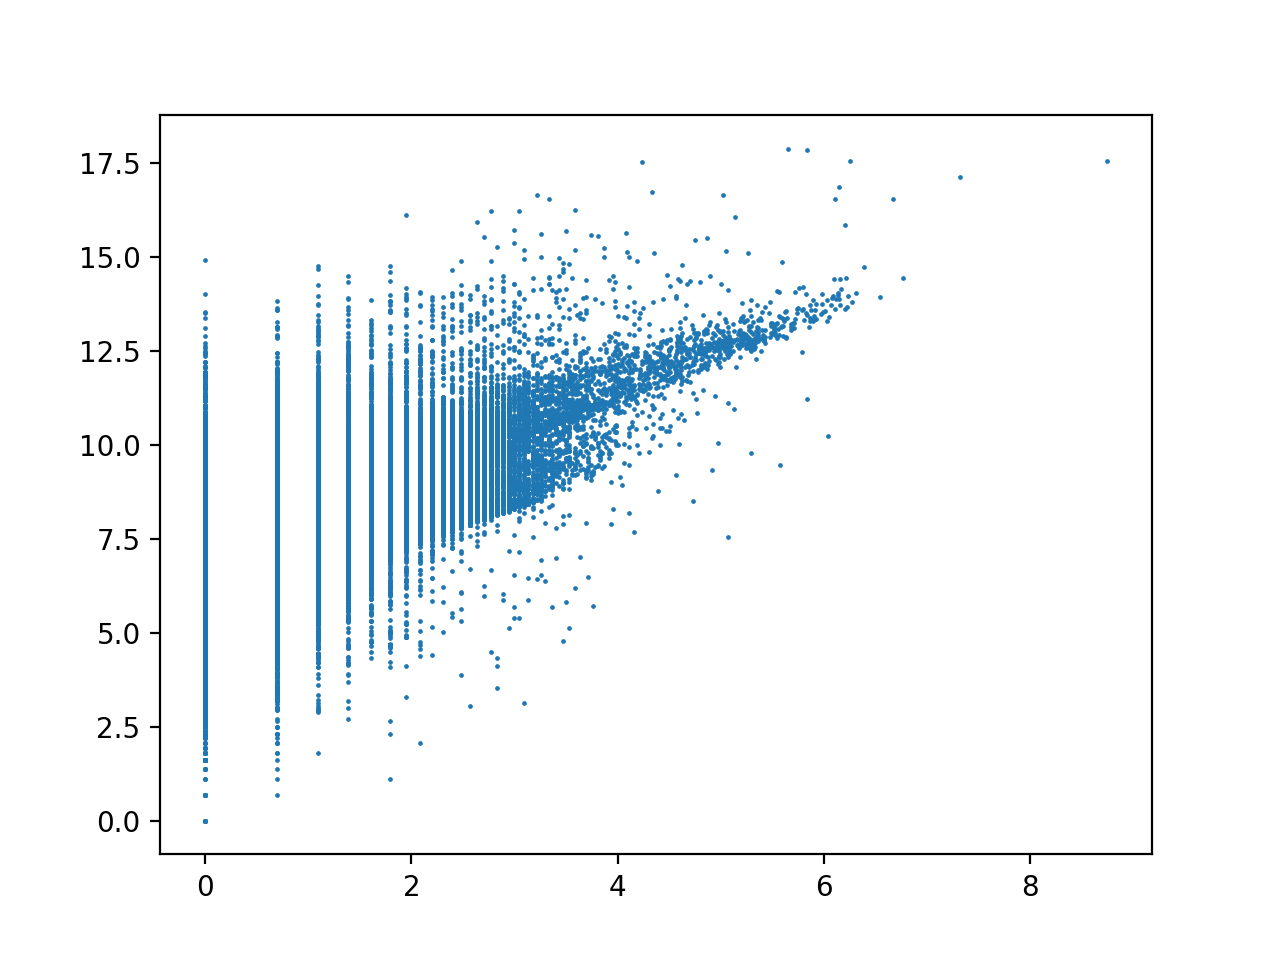

In [136]:
plot_log_log(outweights)

<IPython.core.display.Javascript object>


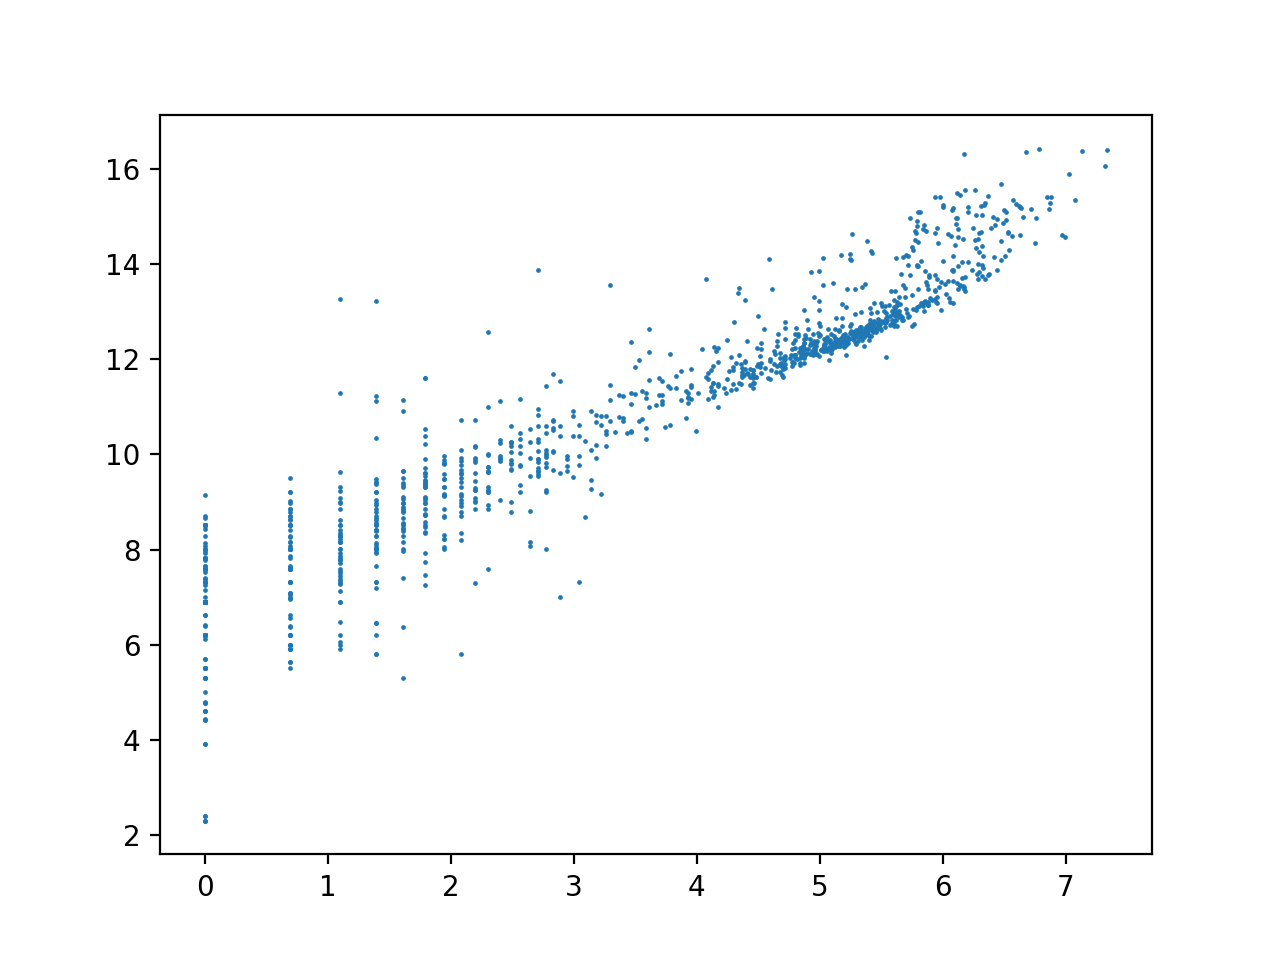

In [135]:
plot_log_log(inweights)

<IPython.core.display.Javascript object>


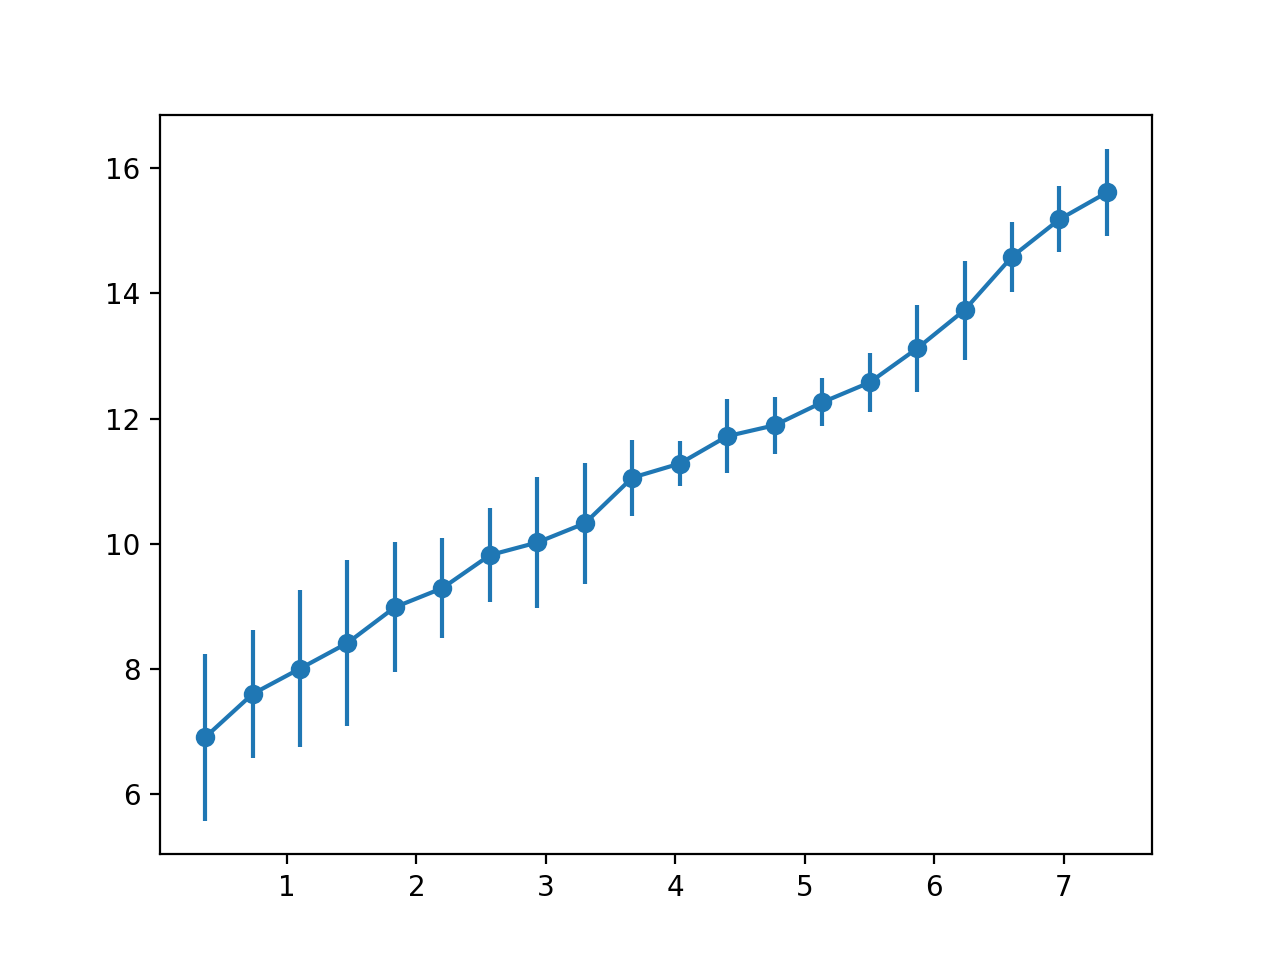

In [235]:
plot_log_log_median(inweights,B=20)

### Edge weight power law

In [240]:
def get_edge_weights(records):
    # For each existing edge in the record, merges duplicates by adding them up
    edge_weights = {}
    for i in range(records.shape[0]):
        # Add newly found weight
        edge_weights[(records[i,0], records[i,1])] = edge_weights.get((records[i,0], records[i,1]), 0) + records[i,2]
    return edge_weights

def get_ewpl(records, edge_weights, maxIndex):
    # Records is either Don2Com or Com2Cand
    # First get (the degree and) incident weight data on each candidate/donor
    # Summary of column 1
    node_summary = get_degree_and_weight(records, maxIndex)
    # Get (the degree and) incident weight data on each committee
    # I swap the first two columns in the record to do this
    # Summary of column 0 
    comm_summary = get_degree_and_weight(records[:,np.array([1,0,2])], NumCommittees)
    # Now we need to generate a list of ordered pairs of the
    # form(edge-weight, sqrt(weights incident on end points)) 
    # But before that we need to merge records corresponding to same (i,j)
    # Each edge is (committee, candidate)
    #edge_weights = get_edge_weights(records)
    # Update: This should be passed

    x = []
    y = []
    #results = np.zeros((len(edge_weights.keys()),2))
    for edge in edge_weights.keys():
        # Add edge weight as x value
        #edge = edge_weights.keys()[i]
        val = edge_weights[edge]
        x += [edge_weights[edge]]
        # Add product of incident weights
        y += [(node_summary[edge[1],1]-val)*(comm_summary[edge[0],1]-val)]
        #results[i,1] = (cand_summary[edge[1],1]-val)*(comm_summary[edge[0],1]-val)
        #results[i,0] = val
    return np.asarray(zip(x,y))

In [ ]:
Don2ComFinal_ew = get_edge_weights(records)
Com2CandFinal_ew = get_edge_weights(records)

In [201]:
Don2Com_ewpl = get_ewpl(Don2ComFinal, Don2ComFinal_ew, NumDonors)

1039930


<IPython.core.display.Javascript object>


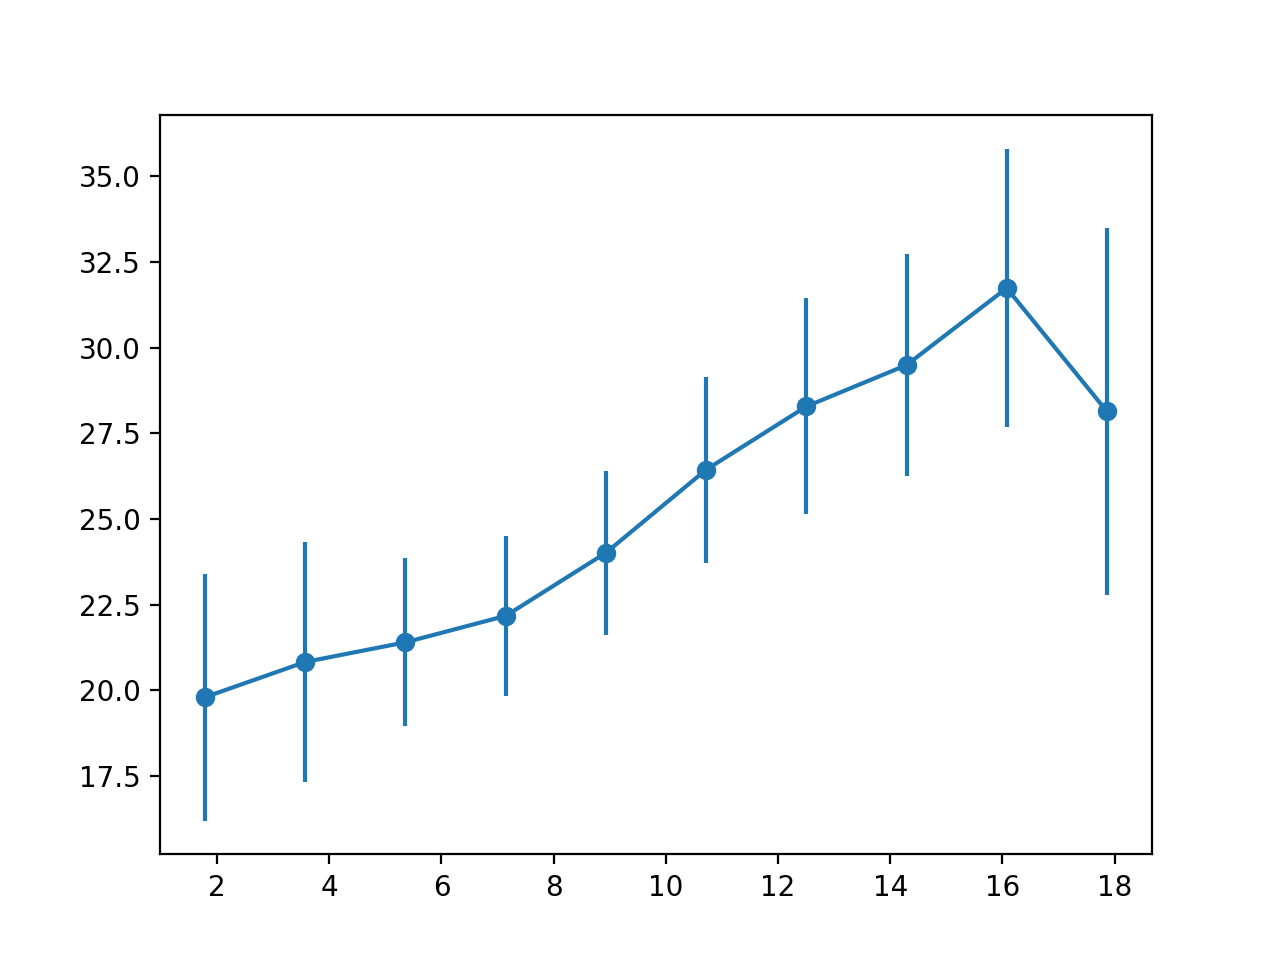

In [236]:
plot_log_log_median(Don2Com_ewpl,10)

## Edge weight vs Mutual neighbors

In [290]:
def get_neighborhood(records):
    # each key is a node in column 1 and each value is a set nodes from column 0
    nbrs = {}
    for i in tqdm(range(records.shape[0])):
        nbrs[records[i,1]]=nbrs.get(records[i,1],set()).union(set([records[i,0]]))
    return nbrs

def get_mutual(nbr_1, nbr_2, i, j):
    # Find nbr2 of nbr 1 of j and nbr2 of j
    result = set()
    for j_prime in nbr_1.get(i,set()):
        result = result.union(nbr_2.get(j_prime, set()))
    return len(result.intersection(nbr_2.get(j,set())))
    
def ew_mutual(records, edge_weights, maxIndex):
    # each key is a node/comm and each value is a set of comm/nodes
    node_neighbors = get_neighborhood(records)
    comm_neighbors = get_neighborhood(records[:,np.array([1,0])])
    #edge_weights =  get_edge_weights(records)
    x = []
    y = []
    random_idx = np.random.randint(len(edge_weights.keys()),size=100)
    edges = edge_weights.keys()
    for i in random_idx:
        # Add edge weight as x value
        #edge = edge_weights.keys()[i]
        edge = edges[i]
        val = edge_weights[edge]
        x += [edge_weights[edge]]
        # Add product of incident weights
        y += [get_mutual(node_neighbors, comm_neighbors, edge[1], edge[0])*get_mutual(comm_neighbors, node_neighbors, edge[0], edge[1])]


    return np.asarray(zip(x,y))

## Self-similarity

In [ ]:
#def self_similarity(records):
records = Don2ComFinal
# First create scipy adjacency matrix
maxNodeIndex = NumDonors
maxCommIndex = NumCommittees
adjacency = sparse.bsr_matrix(np.zeros((maxCommIndex, maxNodeIndex)))
edge_weights =  Don2ComFinal_ew
for edge in edge_weights.keys():
    adjacency[edge[0], edge[1]] += edge_weights[edge]
    